HTML(value='<h3>Figure A — Browser</h3>')

HTML(value='<h3>Figure B — Reverse Image Search</h3>')

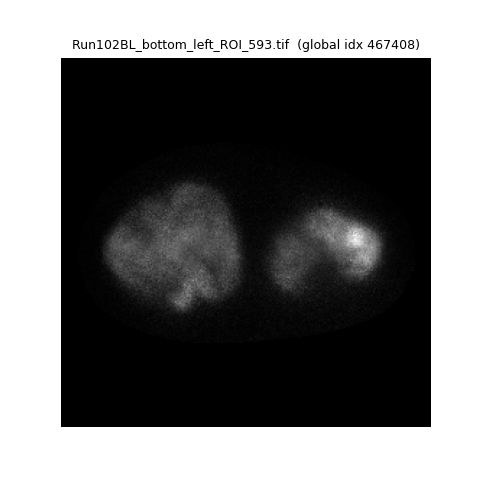

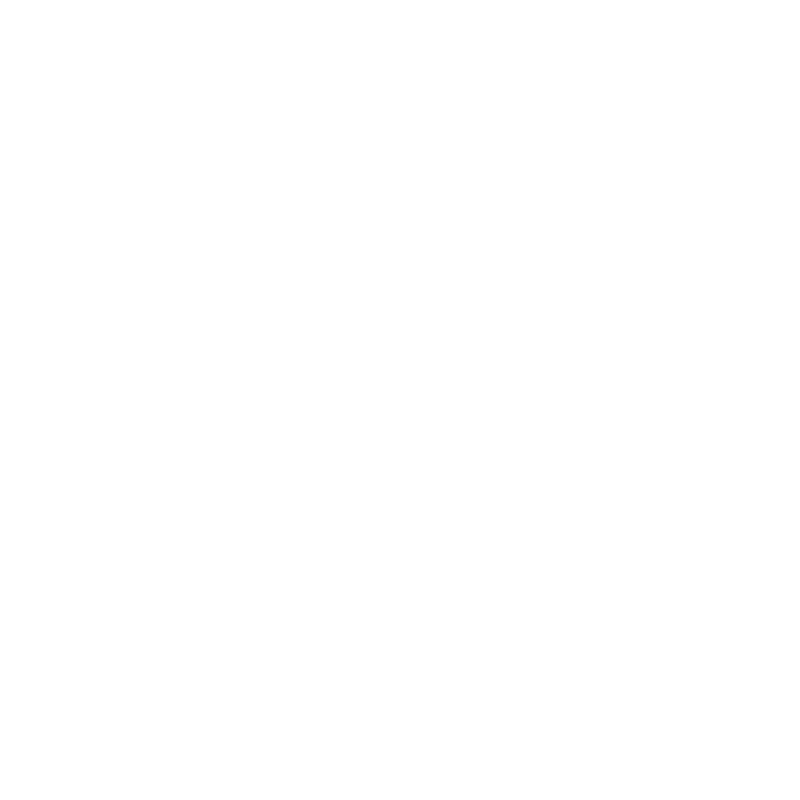

In [1]:
# Interactive browse + reverse image search (A & B) for AE latents
# H5-only version: uses latents.h5 (/z and /filenames). No TF required.

import os, math
from functools import lru_cache
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from tifffile import imread
import ipywidgets as W
from IPython.display import display

# ───────────────────────────────────────────────────────────────────────────────
# Backend for interactive Matplotlib in JupyterLab
# ───────────────────────────────────────────────────────────────────────────────
try:
    from IPython import get_ipython
    ip = get_ipython()
    if ip is not None:
        ip.run_line_magic("matplotlib", "widget")  # requires ipympl
except Exception:
    pass  # falls back to inline if ipympl isn't active

# ───────────────────────────────────────────────────────────────────────────────
# CONFIG — update paths as needed
# ───────────────────────────────────────────────────────────────────────────────
AE_RESULTS_DIR   = r"D:/Results/09052025_AE1M_Conv2DTranspose"  # folder that contains latents.h5
LATENTS_H5       = os.path.join(AE_RESULTS_DIR, "latents.h5")   # expects datasets: /z, /filenames
IMAGE_ROOT       = r"D:/Confocal_imaging_nuclei_tif/MIST_Fused_Images/ROIs"

SAMPLE_SIZE      = 10_000     # how many to browse in Figure A (search still uses FULL index)
TOPK             = 16         # neighbors grid size in Figure B (4..64 is typical)
PRELOAD_LATENTS  = True       # True = load all latents to RAM; False = chunked search
CHUNK_SIZE       = 50_000     # used only when PRELOAD_LATENTS=False

# ───────────────────────────────────────────────────────────────────────────────
# Load filenames + latents
# ───────────────────────────────────────────────────────────────────────────────
assert os.path.isfile(LATENTS_H5), f"latents.h5 not found at: {LATENTS_H5}"

hf = h5py.File(LATENTS_H5, "r")
z_ds = hf["z"]                  # (N, latent_dim) float32
raw_fns = hf["filenames"][:]    # vlen/utf-8 or bytes
file_names = [(x.decode("utf-8") if isinstance(x, (bytes, bytearray)) else str(x)) for x in raw_fns]
N, latent_dim = z_ds.shape

if PRELOAD_LATENTS:
    z_all = z_ds[...].astype(np.float32)  # RAM copy
    z_norms = np.linalg.norm(z_all, axis=1) + 1e-9
else:
    z_all = None
    z_norms = None

fname_to_idx = {fn: i for i, fn in enumerate(file_names)}

# ───────────────────────────────────────────────────────────────────────────────
# Sampling for Figure A
# ───────────────────────────────────────────────────────────────────────────────
def make_sample(seed=1234):
    rng = np.random.default_rng(seed)
    if SAMPLE_SIZE >= N:
        idxs = np.arange(N, dtype=np.int64)
    else:
        idxs = rng.choice(N, size=SAMPLE_SIZE, replace=False)
    return idxs

sample_seed = 1234
sample_indices = make_sample(sample_seed)

# ───────────────────────────────────────────────────────────────────────────────
# Image I/O
# ───────────────────────────────────────────────────────────────────────────────
def to_abs_path(fn):
    # Join with IMAGE_ROOT unless already absolute
    return fn if os.path.isabs(fn) else os.path.join(IMAGE_ROOT, fn)

@lru_cache(maxsize=4096)
def load_img_for_display(fn):
    """Load TIFF and return float32 image in [0,1] for display."""
    p = to_abs_path(fn)
    arr = imread(p).astype(np.float32)
    a, b = arr.min(), arr.max()
    if b > a:
        disp = (arr - a) / (b - a)
    else:
        disp = np.zeros_like(arr, dtype=np.float32)
    return disp

def latent_for_index(idx):
    return (z_all[idx] if z_all is not None else z_ds[idx])

# ───────────────────────────────────────────────────────────────────────────────
# Top-K neighbor search over FULL index
# ───────────────────────────────────────────────────────────────────────────────
def topk_neighbors(q_vec, k=TOPK, metric="cosine"):
    """
    Returns (indices, scores) of top-K matches across the FULL dataset.
    metric: 'cosine' (higher=better) or 'euclidean' (lower=better)
    """
    if z_all is not None:
        # In-RAM search
        if metric == "cosine":
            qn = np.linalg.norm(q_vec) + 1e-9
            scores = (z_all @ q_vec) / (z_norms * qn)
            part = np.argpartition(scores, -k)[-k:]
            order = np.argsort(scores[part])[::-1]
            top_idx = part[order]
            return top_idx, scores[top_idx]
        else:
            dif = z_all - q_vec
            d2 = np.einsum("ij,ij->i", dif, dif)  # squared distances
            part = np.argpartition(d2, k)[:k]
            order = np.argsort(d2[part])
            top_idx = part[order]
            return top_idx, np.sqrt(d2[top_idx]).astype(np.float32)
    else:
        # Chunked H5 search (lower RAM)
        best_idx = np.empty(0, dtype=np.int64)
        best_scores = np.empty(0, dtype=np.float32)
        start = 0
        if metric == "cosine":
            qn = np.linalg.norm(q_vec) + 1e-9
        while start < N:
            end = min(start + CHUNK_SIZE, N)
            Z = z_ds[start:end].astype(np.float32)
            if metric == "cosine":
                norms = np.linalg.norm(Z, axis=1) + 1e-9
                scores = (Z @ q_vec) / (norms * qn)
                c_part = np.argpartition(scores, -k)[-k:]
                c_idx = start + c_part
                c_scores = scores[c_part]
                best_idx = np.concatenate([best_idx, c_idx])
                best_scores = np.concatenate([best_scores, c_scores])
                g_part = np.argpartition(best_scores, -k)[-k:]
                best_idx, best_scores = best_idx[g_part], best_scores[g_part]
            else:
                dif = Z - q_vec
                d2 = np.einsum("ij,ij->i", dif, dif)
                c_part = np.argpartition(d2, k)[:k]
                c_idx = start + c_part
                c_scores = np.sqrt(d2[c_part]).astype(np.float32)
                best_idx = np.concatenate([best_idx, c_idx])
                best_scores = np.concatenate([best_scores, c_scores])
                g_part = np.argpartition(best_scores, k)[:k]
                best_idx, best_scores = best_idx[g_part], best_scores[g_part]
            start = end
        order = np.argsort(best_scores)[::-1] if metric == "cosine" else np.argsort(best_scores)
        return best_idx[order], best_scores[order]

# ───────────────────────────────────────────────────────────────────────────────
# UI
# ───────────────────────────────────────────────────────────────────────────────
idx_slider   = W.IntSlider(value=0, min=0, max=len(sample_indices)-1, step=1,
                           description="Index", continuous_update=False, readout=True)
metric_dd    = W.Dropdown(options=["cosine", "euclidean"], value="cosine", description="Metric")
k_slider     = W.IntSlider(value=TOPK, min=4, max=64, step=4, description="Top-K", continuous_update=False)
go_button    = W.Button(description="GO: Search neighbors", button_style="success")
seed_box     = W.IntText(value=sample_seed, description="Sample seed")
reshuffle_btn= W.Button(description=f"Reshuffle {SAMPLE_SIZE:,}", button_style="info")
status_txt   = W.HTML(value=f"<b>Mode:</b> H5 full index (N={N:,}, latent_dim={latent_dim}).")

controls_row1 = W.HBox([idx_slider, metric_dd, k_slider])
controls_row2 = W.HBox([seed_box, reshuffle_btn, go_button])
controls_box  = W.VBox([controls_row1, controls_row2, status_txt])

display(W.HTML("<h3>Figure A — Browser</h3>"))
display(controls_box)

figA, axA = plt.subplots(figsize=(4.8, 4.8))
try:
    figA.canvas.header_visible = False
    figA.canvas.resizable = True
except Exception:
    pass

display(W.HTML("<h3>Figure B — Reverse Image Search</h3>"))
figB = plt.figure(figsize=(8, 8))
try:
    figB.canvas.header_visible = False
    figB.canvas.resizable = True
except Exception:
    pass

# ───────────────────────────────────────────────────────────────────────────────
# Draw helpers
# ───────────────────────────────────────────────────────────────────────────────
def current_global_index():
    return int(sample_indices[int(idx_slider.value)])

def show_image_A():
    gidx = current_global_index()
    fn = file_names[gidx]
    img = load_img_for_display(fn)
    axA.clear()
    axA.imshow(img, cmap="gray")
    axA.set_title(f"{fn}  (global idx {gidx})", fontsize=9)
    axA.axis("off")
    figA.canvas.draw_idle()

def grid_shape(k):
    r = int(math.floor(math.sqrt(k)))
    c = int(math.ceil(k / max(r,1)))
    return r, c

def show_neighbors_B(q_idx, top_idx, scores, metric):
    figB.clf()
    k = len(top_idx)
    rows, cols = grid_shape(k)
    for i, (midx, score) in enumerate(zip(top_idx, scores)):
        ax = figB.add_subplot(rows, cols, i+1)
        mfn = file_names[midx]
        mimg = load_img_for_display(mfn)
        ax.imshow(mimg, cmap="gray")
        ax.set_title(f"{score:.3f}", fontsize=8)
        ax.axis("off")
        if midx == q_idx:
            h, w = mimg.shape
            rect = Rectangle((0,0), w, h, linewidth=3, edgecolor="red", facecolor="none")
            ax.add_patch(rect)
    figB.tight_layout()
    figB.canvas.draw_idle()

# ───────────────────────────────────────────────────────────────────────────────
# Callbacks
# ───────────────────────────────────────────────────────────────────────────────
def on_index_change(change):
    if change["name"] == "value":
        show_image_A()

def on_go_clicked(_):
    status_txt.value = "<em>Searching…</em>"
    gidx = current_global_index()
    q_vec = latent_for_index(gidx).astype(np.float32)
    metric = metric_dd.value
    k = int(k_slider.value)
    top_idx, scores = topk_neighbors(q_vec, k=k, metric=metric)
    show_neighbors_B(gidx, top_idx, scores, metric)
    status_txt.value = f"<b>Done.</b> Query = global idx {gidx} (<code>{file_names[gidx]}</code>)"

def on_reshuffle_clicked(_):
    global sample_indices
    seed = int(seed_box.value)
    load_img_for_display.cache_clear()  # avoid cache bloat on reshuffles
    new_sample = make_sample(seed)
    idx_slider.max = len(new_sample) - 1
    sample_indices = new_sample
    status_txt.value = f"Resampled {len(new_sample):,} with seed {seed} (from N={N:,})."
    show_image_A()
    figB.clf(); figB.canvas.draw_idle()

idx_slider.observe(on_index_change, names="value")
go_button.on_click(on_go_clicked)
reshuffle_btn.on_click(on_reshuffle_clicked)

# initial draw
show_image_A()
